In [1]:
from seq2seq import *
import tltk, jiwer
import pandas as pd

In [7]:
### load data
train_x = open('data/train_x.txt').read().splitlines()
train_y = open('data/train_y.txt').read().splitlines()
test_x = open('data/test_x.txt').read().splitlines()
test_y = open('data/test_y.txt').read().splitlines()

### additional dict data
dic_x = open('data/dic_x.txt').read().splitlines()
dic_y = open('data/dic_y.txt').read().splitlines()

In [8]:
### Instantiation
data = Data()
data.set_train(train_x, train_y)
data.set_test(test_x, test_y)

### set dict data
data.set_train(dic_x, dic_y)

In [9]:
### build no attention model
seq2seq1 = Seq2Seq(data, attention=False)
seq2seq1.build(show_summary=True)

### build attention model
seq2seq2 = Seq2Seq(data, attention=True)
seq2seq2.build(show_summary=True)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Enc_Input (InputLayer)         [(None, 55)]         0           []                               
                                                                                                  
 Enc_Embedding (Embedding)      (None, 55, 256)      18688       ['Enc_Input[0][0]']              
                                                                                                  
 Dec_Input (InputLayer)         [(None, 69)]         0           []                               
                                                                                                  
 BiDir (Bidirectional)          [(None, 256),        394240      ['Enc_Embedding[0][0]']          
                                 (None, 128),                                               

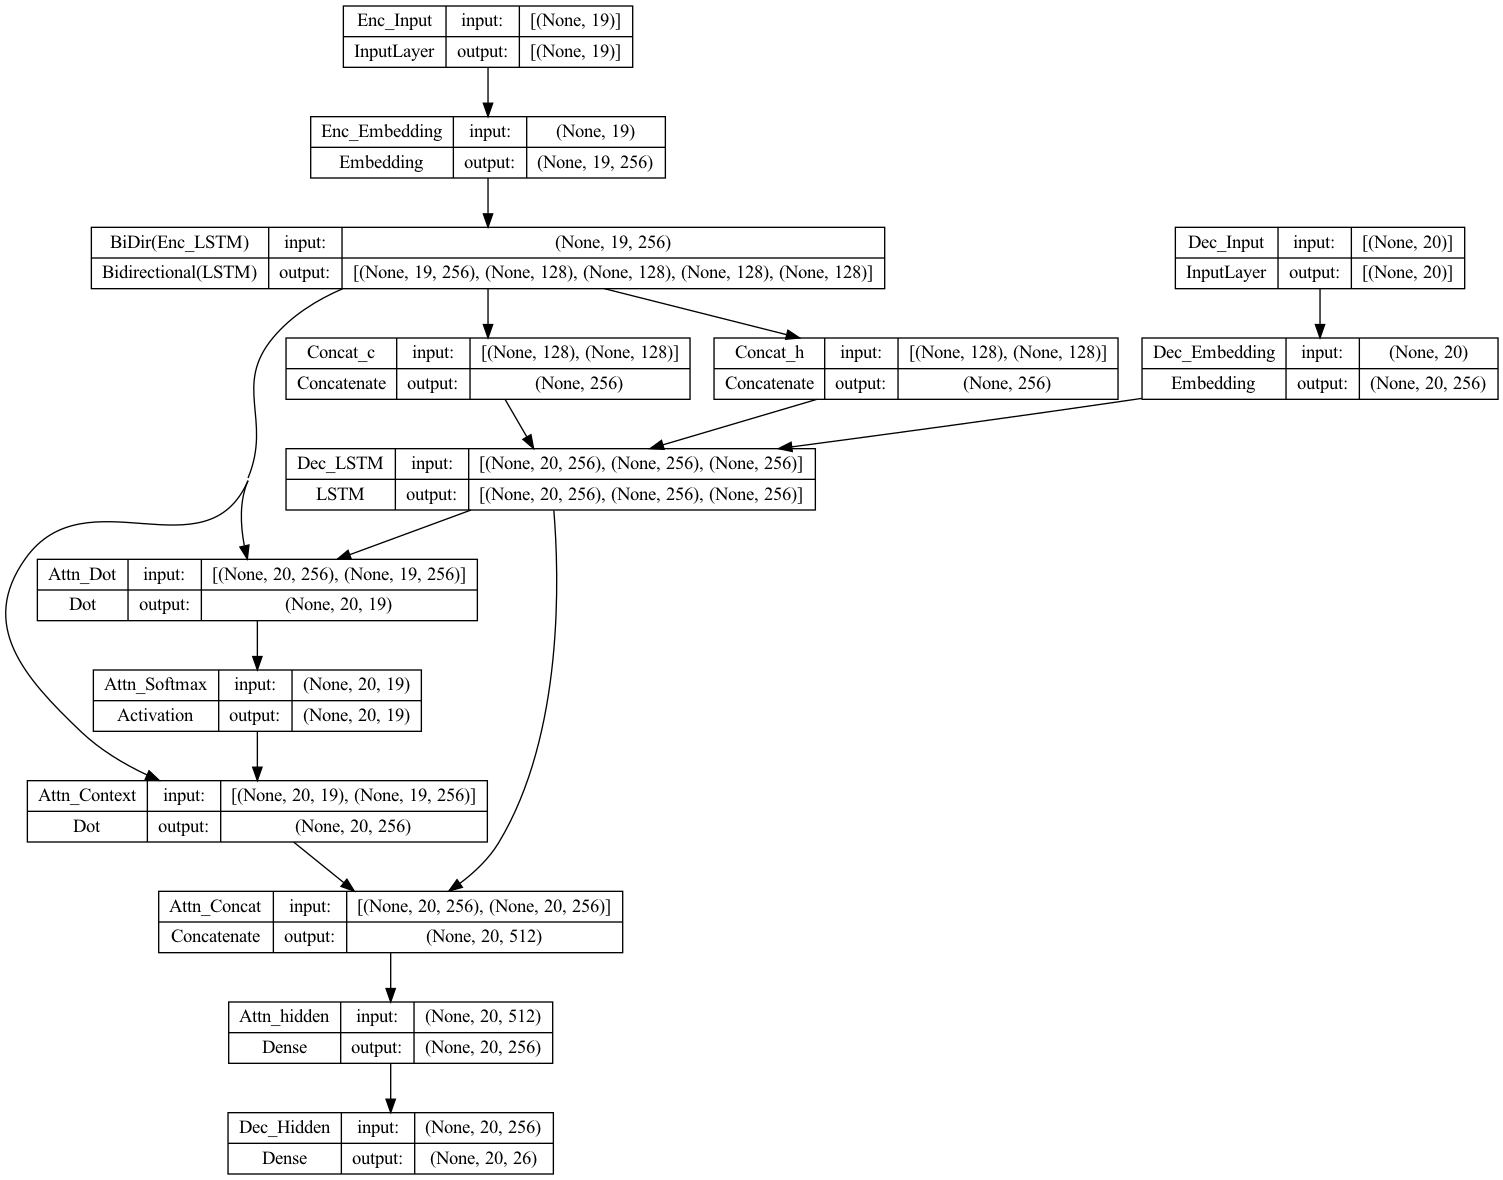

In [5]:
seq2seq2.show_model()

Epoch 1/10
234/234 [==============================] - 192s 819ms/step - loss: 0.0042 - accuracy: 0.9907
Epoch 2/10
234/234 [==============================] - 196s 837ms/step - loss: 0.0040 - accuracy: 0.9910
Epoch 3/10
234/234 [==============================] - 195s 835ms/step - loss: 0.0039 - accuracy: 0.9913
Epoch 4/10
234/234 [==============================] - 193s 825ms/step - loss: 0.0037 - accuracy: 0.9916
Epoch 5/10
234/234 [==============================] - 200s 857ms/step - loss: 0.0036 - accuracy: 0.9918
Epoch 6/10
234/234 [==============================] - 195s 832ms/step - loss: 0.0035 - accuracy: 0.9922
Epoch 7/10
234/234 [==============================] - 186s 796ms/step - loss: 0.0034 - accuracy: 0.9924
Epoch 8/10
234/234 [==============================] - 186s 793ms/step - loss: 0.0034 - accuracy: 0.9923
Epoch 9/10
234/234 [==============================] - 199s 849ms/step - loss: 0.0032 - accuracy: 0.9928
Epoch 10/10
234/234 [==============================] - 187s 800m

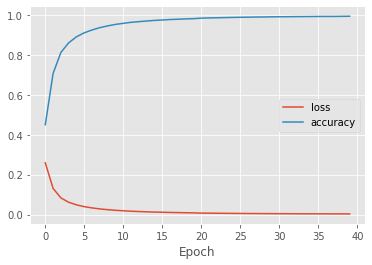

In [19]:
### train
seq2seq1.train(batch_size=128, epoch=10, dev_split=0)
#seq2seq2.train(batch_size=128, epoch=10, dev_split=0)

# save weight

In [24]:
seq2seq1.model.save_weights('model_weight/dict_lstm/weight')
seq2seq2.model.save_weights('model_weight/dict_attn/weight')

# evaluate model

In [20]:
### GREEDY SEARCH
pred1 = seq2seq1.predict(join_by='')
pred2 = seq2seq2.predict(join_by='')
df = pd.DataFrame({'thai':test_x,'pred1':pred1,'pred2':pred2, 'answer':test_y})
pred_tltk = [tltk.nlp.th2roman(x).replace('<s/>','').replace(' ','') for x in list(df.answer)]
df['tltk'] = pred_tltk
df[['thai','answer','tltk','pred1','pred2']].to_csv('pred_result/pred_dict.csv', index=False)

100%|██████████| 716/716 [04:42<00:00,  2.54it/s]


In [22]:
def evaluate(df):
    cols = df.columns
    gold_list = list(df.answer)
    tempdf = pd.DataFrame(index=['WER','CER macro', 'CER micro'])

    for col in cols:
        if col in ['answer', 'thai']:
            continue
        pred_list = list(df[col])
        WER = jiwer.wer(pred_list, gold_list)
        CERmacro = np.mean([jiwer.cer(p,g) for p,g in zip(pred_list, gold_list)])
        CERmicro = sum([jiwer.cer(p,g)*len(g) for p,g in zip(pred_list, gold_list)])/sum([len(g) for g in gold_list])
        tempdf[col] = [WER, CERmacro, CERmicro]
    return tempdf

evaluate(df)

,pred1,pred2,tltk
WER,0.122905,0.090782,0.090782
CER macro,0.035918,0.024459,0.012128
CER micro,0.036534,0.024111,0.012049


In [23]:
### BEAM SEARCH
pred1 = seq2seq1.predict(join_by='',is_beam=True,beam_return_all=False)
pred2 = seq2seq2.predict(join_by='',is_beam=True,beam_return_all=False)
df = pd.DataFrame({'thai':test_x,'pred1':pred1,'pred2':pred2, 'answer':test_y})
pred_tltk = [tltk.nlp.th2roman(x).replace('<s/>','').replace(' ','') for x in list(df.answer)]
df['tltk'] = pred_tltk
df[['thai','answer','tltk','pred1','pred2']].to_csv('pred_result/pred_dict_beam.csv', index=False)

evaluate(df)

100%|██████████| 716/716 [12:32<00:00,  1.05s/it]


,pred1,pred2,tltk
WER,0.117318,0.090782,0.090782
CER macro,0.033874,0.023728,0.012128
CER micro,0.034186,0.023680,0.012049


### coding test

In [40]:
i = np.random.randint(0,810)

print(test_x[i])
print(seq2seq2.predict_one(test_x[i], is_beam=True, beam_return_all=True, join_by=''))
print(test_y[i])

อรรถยา
['atthaya', 'attaya', 'anthaya']
attaya


In [41]:
i = np.random.randint(0,810)

print(test_x[i])
print(seq2seq2.predict_one(test_x[i], is_beam=True, beam_return_all=True, join_by=''))
print(test_y[i])

อาหามะ
['ahama', 'aham', 'ahoma']
ahama


In [42]:
seq2seq3 = Seq2Seq(data, attention=False)
seq2seq3.build(show_summary=False)
seq2seq3.model.load_weights('model_weight/dict_lstm/weight')

In [43]:
i = np.random.randint(0,810)

print(test_x[i])
print(seq2seq3.predict_one(test_x[i], is_beam=True, beam_return_all=True, join_by=''))
print(test_y[i])

สุรักษ์
['surak', 'surarak', 'suram']
surak
